# Packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import ruptures as rpt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
from scipy.spatial import distance

from fastdtw import fastdtw
pd.set_option('display.max_rows', 500)

# Feature extraction functions

### Distance/Displacement

In [2]:
def get_distance(dataframe):
    columns=np.array(dataframe.columns.str.split('_').str.get(-3).drop_duplicates().dropna())
    for i in columns:
        markerDistance=i+'_d'
        print(markerDistance)
        for j,rows in dataframe.iterrows():
            if(j==0):
                dataframe.loc[j, markerDistance] = 0
            else:
                dataframe.loc[j, markerDistance] = math.sqrt((dataframe.loc[j,i+'_Marker_X'] - dataframe.loc[j-1,i+'_Marker_X'])**2 + (dataframe.loc[j,i+'_Marker_Y'] - dataframe.loc[j-1,i+'_Marker_Y'])**2+ (dataframe.loc[j,i+'_Marker_Z'] - dataframe.loc[j-1,i+'_Marker_Z'])**2)            
    return dataframe

### Velocity

In [3]:
def get_velocity(dataframe):
    columns=np.array(dataframe.columns.str.split('_').str.get(-3).drop_duplicates().dropna())
    for i in columns:
        markerVelocity=i+'_v'
        print(markerVelocity)
        for j,rows in dataframe.iterrows():
            if(j==0):
                dataframe.loc[j, markerVelocity] = 0
            else:
                dataframe.loc[j, markerVelocity] = abs((dataframe.loc[j,i+'_d'] - dataframe.loc[j-1,i+'_d']))/(time_step)            
    return dataframe

### Acceleration

In [4]:
def get_acceleration(dataframe):
    columns=np.array(dataframe.columns.str.split('_').str.get(-3).drop_duplicates().dropna())
    for i in columns:
        markerAcceleration=i+'_a'
        print(markerAcceleration)
        for j,rows in dataframe.iterrows():
            if(j==0):
                dataframe.loc[j, markerAcceleration] = 0
            else:
                dataframe.loc[j, markerAcceleration] = abs((dataframe.loc[j,i+'_v'] - dataframe.loc[j-1,i+'_v']))/(time_step)            
    return dataframe

### Kinetic Energy / Motion Index / Perceived Energy

In [5]:
def get_KE(dataframe, mass):
    columns=np.array(dataframe.columns.str.split('_').str.get(-3).drop_duplicates().dropna())
    for i in columns:
        markerKE=i+'_KE'
        print(markerKE)
        for j,rows in dataframe.iterrows():
            if(j==0):
                dataframe.loc[j, markerKE] = 0
            else:
                dataframe.loc[j, markerKE] = (dataframe.loc[j,i+'_v']**2)*(mass)*0.5
    return dataframe

### Contraction & Expansion 

In [6]:
def get_baryCenter(dataframe):
    columns=['BackRight','BackLeft','WaistLBack','WaistRBack']
    baryCenter="baryCenter"
    print(baryCenter)
    for j,rows in dataframe.iterrows():
        dataframe.loc[j, baryCenter+"_X"] = (dataframe.loc[j, columns[0]+"_Marker_X"]+dataframe.loc[j, columns[1]+"_Marker_X"]+dataframe.loc[j, columns[2]+"_Marker_X"]+dataframe.loc[j, columns[3]+"_Marker_X"])/4
        dataframe.loc[j, baryCenter+"_Y"] = (dataframe.loc[j, columns[0]+"_Marker_Y"]+dataframe.loc[j, columns[1]+"_Marker_Y"]+dataframe.loc[j, columns[2]+"_Marker_Y"]+dataframe.loc[j, columns[3]+"_Marker_Y"])/4
        dataframe.loc[j, baryCenter+"_Z"] = (dataframe.loc[j, columns[0]+"_Marker_Z"]+dataframe.loc[j, columns[1]+"_Marker_Z"]+dataframe.loc[j, columns[2]+"_Marker_Z"]+dataframe.loc[j, columns[3]+"_Marker_Z"])/4
    return dataframe

In [7]:
def get_contractionIndex(dataframe):    
    columns=['HeadTop','LWristOut','RWristOut','LToeOut','RToeOut']
    CI="contractionIndex"
    for j,rows in dataframe.iterrows():
        sum=0
        for i in columns:
            temp_sum = math.sqrt((dataframe.loc[j,i+'_Marker_X'] - dataframe.loc[j,'baryCenter_X'])**2 + (dataframe.loc[j,i+'_Marker_Y'] - dataframe.loc[j,'baryCenter_Y'])**2+ (dataframe.loc[j,i+'_Marker_Z'] - dataframe.loc[j,'baryCenter_Z'])**2)
            sum=sum+temp_sum
        dataframe.loc[j, CI] = sum 
    dataframe[CI]=(dataframe[CI]-dataframe[CI].min())/(dataframe[CI].max()-dataframe[CI].min())
    return dataframe

# Fixed variables

In [8]:
frequency=120
time_step=1/frequency

## Key-point selection

In [9]:
keyPointsInterest=['HeadTop','RHandOut','BackRight','BackLeft','WaistLBack','WaistRBack','LWristOut','RWristOut','LToeOut','RToeOut']
finalKeyPoints=[]
for i in keyPointsInterest:
    finalKeyPoints.extend([i+"_Marker_X",i+"_Marker_Y",i+"_Marker_Z"])

## Phrase 3 ID - 1

## Load data

In [134]:
data_path="C:\San\PhD-Data\AndreasBergland\AudioMostly23\MoCap_GapfFilled\GapFilled20\Phrase3_ID1_GF20.csv"

In [135]:
df=pd.read_csv(data_path).reset_index(drop=True)

In [136]:
df.isnull().sum()

BackLeft_Marker_X            0
BackLeft_Marker_Y            0
BackLeft_Marker_Z            0
BackRight_Marker_X           0
BackRight_Marker_Y           0
BackRight_Marker_Z           0
BackTop_Marker_X             0
BackTop_Marker_Y             0
BackTop_Marker_Z             0
Chest_Marker_X             148
Chest_Marker_Y             148
Chest_Marker_Z             148
HeadFront_Marker_X           0
HeadFront_Marker_Y           0
HeadFront_Marker_Z           0
HeadSide_Marker_X          147
HeadSide_Marker_Y          147
HeadSide_Marker_Z          147
HeadTop_Marker_X             0
HeadTop_Marker_Y             0
HeadTop_Marker_Z             0
LAnkleOut_Marker_X           0
LAnkleOut_Marker_Y           0
LAnkleOut_Marker_Z           0
LElbowOut_Marker_X           0
LElbowOut_Marker_Y           0
LElbowOut_Marker_Z           0
LHandOut_Marker_X            0
LHandOut_Marker_Y            0
LHandOut_Marker_Z            0
LKneeOut_Marker_X          577
LKneeOut_Marker_Y          577
LKneeOut

In [137]:
df=df[finalKeyPoints]

## Split Files into separate takes  

##### Phrase 3 ID 1

In [138]:
take_ranges = [(2048, 3883), (4688, 6483), (7328, 8958), (10088, 11688)]
dfs = [df.iloc[start:end].reset_index(drop=True) for start, end in take_ranges]

take_starts = [start for start, end in take_ranges]
tp_coords_1 = [3061, 3421, 3632]
tp_coords_2 = [5595, 5938, 6176]
tp_coords_3 = [8124, 8425, 8673]
tp_coords_4 = [10828, 11139, 11376]

tp_coords = [[value - start for value in tp_coords] for start, tp_coords in zip(take_starts, [tp_coords_1, tp_coords_2, tp_coords_3, tp_coords_4])]

#### Take 1 

In [139]:
dataCopy=dfs[0].copy()

In [140]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


In [141]:
dataCopy

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,WaistLBack_KE,WaistRBack_KE,LWristOut_KE,RWristOut_KE,LToeOut_KE,RToeOut_KE,baryCenter_X,baryCenter_Y,baryCenter_Z,contractionIndex
0,3.536350,1.470390,4.796988,3.872764,0.690779,4.708443,3.533486,1.007474,4.811824,3.382627,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.409758,0.909797,4.799403,0.388098
1,3.536276,1.470403,4.797054,3.872389,0.690475,4.708428,3.533502,1.007501,4.811874,3.382650,...,2.500560e-05,4.302720e-05,1.462896e-04,0.001648,5.544000e-07,3.259440e-04,3.409798,0.909802,4.799406,0.387915
2,3.536192,1.470413,4.797095,3.872034,0.689997,4.708672,3.533544,1.007502,4.811899,3.382673,...,1.882721e-05,1.969755e-05,2.381880e-06,0.000042,1.497114e-06,1.813643e-04,3.409842,0.909799,4.799407,0.387698
3,3.536132,1.470412,4.797136,3.871682,0.689784,4.708642,3.533555,1.007502,4.811904,3.382698,...,8.972793e-06,1.008074e-05,7.683065e-06,0.000003,2.661349e-07,2.999064e-06,3.409869,0.909789,4.799384,0.387418
4,3.536079,1.470408,4.797172,3.871315,0.689833,4.708398,3.533580,1.007512,4.811906,3.382712,...,4.960594e-06,7.366268e-07,9.495926e-06,0.000021,6.852001e-07,9.254267e-06,3.409903,0.909771,4.799364,0.387149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,-0.176092,0.572018,2.055709,-0.157428,0.729062,2.416599,0.232329,0.649068,2.236109,0.139706,...,1.636475e-06,4.919537e-04,1.010310e-02,0.000135,4.319171e-04,2.005054e-10,0.188671,0.726662,2.413794,0.022396
1831,-0.175320,0.571752,2.055243,-0.157480,0.729152,2.416216,0.232933,0.648998,2.236093,0.139948,...,5.984716e-07,5.174834e-04,1.298937e-02,0.000152,3.093506e-08,6.072067e-07,0.188899,0.726516,2.413756,0.022369
1832,-0.174755,0.571748,2.054771,-0.157482,0.729093,2.416324,0.233347,0.648986,2.236167,0.140336,...,1.173307e-05,5.281727e-06,1.439263e-07,0.000230,5.597114e-07,3.929066e-08,0.189168,0.726517,2.413753,0.022854
1833,-0.174244,0.571976,2.054223,-0.157364,0.728797,2.416461,0.233184,0.648986,2.236266,0.140704,...,1.552375e-05,6.488393e-06,9.727355e-06,0.000021,3.381744e-06,3.581682e-07,0.189272,0.726498,2.413767,0.023192


In [142]:
validator1_coords=[569,1028,1148,1451,1703]
validator2_coords=[632,1143,1447,1668]
novelty_peaks = [231,475,839,956,1200]
rms_peaks = [481,841,961,1020,1069,1140,1167]
spectral_flux_peaks = [480,840,892,960,983,1001,1021,1071,1106,1139,1170]
brightness_peaks = [461,941,1163]

In [143]:
buffer = 495
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

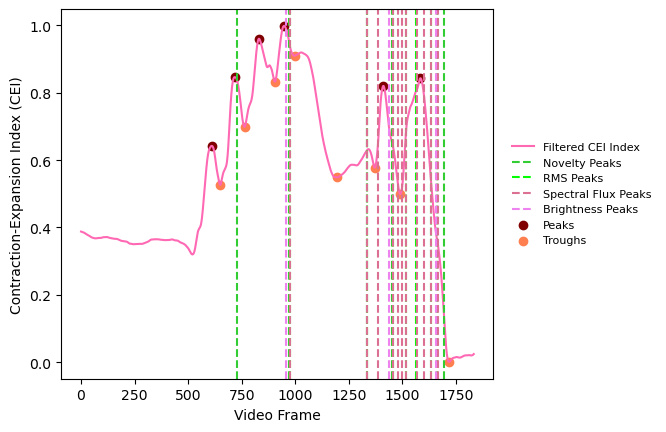

Peaks: [ 610  717  830  948 1411 1584]
Troughs: [ 650  763  905  997 1196 1371 1490 1718]
Coinciding Peaks with Novelty Peaks: []
Coinciding Peaks with RMS Peaks: []
Coinciding Peaks with Spectral Flux Peaks: []
Coinciding Peaks with Brightness Peaks: [(948, 956)]
Coinciding Troughs with Novelty Peaks: []
Coinciding Troughs with RMS Peaks: []
Coinciding Troughs with Spectral Flux Peaks: [(1490, 1496)]
Coinciding Troughs with Brightness Peaks: []
Number of Novelty Peaks: 5.00
Number of RMS Peaks: 7.00
Number of Spectral Flux Peaks: 11.00
Number of Brightness Peaks: 3.00
Percentage of Coinciding Peaks with Novelty Peaks: 0.00%
Percentage of Coinciding Peaks with RMS Peaks: 0.00%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Peaks with Brightness Peaks: 33.33%
Percentage of Coinciding Troughs with Novelty Peaks: 0.00%
Percentage of Coinciding Troughs with RMS Peaks: 0.00%
Percentage of Coinciding Troughs with Spectral Flux Peaks: 9.09%
Percentage 

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

peaks = peaks[3:]
troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'palevioletred', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'violet', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

#### Take 2

In [33]:
dataCopy=dfs[1].copy()

In [34]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


In [37]:
validator1_coords=[529,992,1363,1616]
novelty_peaks = [231,475,839,956,1200]
rms_peaks = [481,841,961,1020,1069,1140,1167]
spectral_flux_peaks = [480,840,892,960,983,1001,1021,1071,1106,1139,1170]
brightness_peaks = [461,941,1163]

buffer = 436
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

In [ ]:
\begin{table*}[tp]
  \caption{Summary statistics of coinciding peaks and troughs}
  \label{tab:two}
  \begin{tabularx}{\linewidth}{cXXXXXXXXXXXXXXXXXXXX}
    \toprule
    & \multicolumn{4}{c}{Acceleration peaks} & \multicolumn{4}{c}{CEI peaks} & \multicolumn{4}{c}{CEI troughs} \\
    \cmidrule(lr){2-5} \cmidrule(lr){6-9} \cmidrule(lr){10-13}
    Particulars & Nov & RMS & SF & Brt & Nov & RMS & SF & Brt & Nov & RMS & SF & Brt \\
    \midrule
    % Min & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
    % Max & 0.00 & 0.00 & 0.00 & 0.00 & 40.00 & 14.29 & 33.33 & 50.00 & 50.00 & 33.33 & 20.00 & 100.00 \\
    Median      & 18.5 & 21.55 & 26 & 4.55 & 0 & 0 & 4.55 & 0 & 0 & 0 & 0 & 0 \\
    Mean        & 16.44 & 22.12 & 25.38 & 8.86 & 8.1 & 7.6 & 11 & 7.14 & 5.71 & 4.59 & 3.38 & 8.33 \\
    Std. Deviation & 7.16 & 10.41 & 8.22 & 10.17 & 14.12 & 12.23 & 12.84 & 14.19 & 9.38 & 9.44 & 6.13 & 16.98 \\
    % Skewness & 0.00 & 0.00 & 0.00 & 0.00 & 1.20 & 3.74 & 0.96 & 0.89 & 1.52 & 0.92 & 0.55 & 3.74 \\
    % Kurtosis & 0.00 & 0.00 & 0.00 & 0.00 & -0.51 & 14.00 & -0.22 & -1.07 & 1.94 & -0.64 & -1.03 & 14.00 \\
    \bottomrule
  \end{tabularx}
\end{table*}

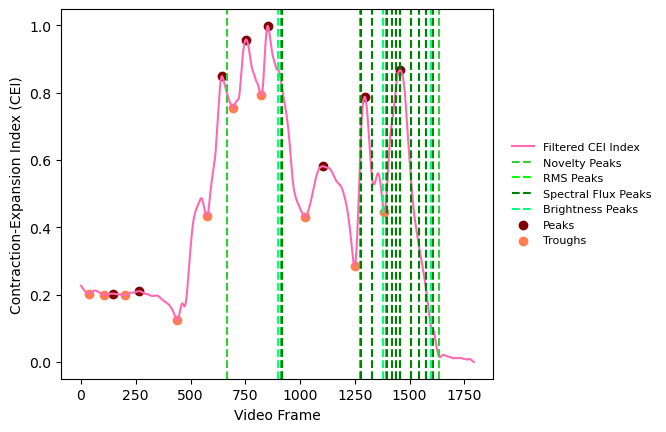

Peaks: [ 144  266  643  753  852 1105 1295 1457]
Troughs: [  35  105  201  438  575  692  822 1023 1249 1384]
Coinciding Peaks with Novelty Peaks: []
Coinciding Peaks with RMS Peaks: [(1457, 1456)]
Coinciding Peaks with Spectral Flux Peaks: [(1457, 1457)]
Coinciding Peaks with Brightness Peaks: []
Coinciding Troughs with Novelty Peaks: [(1384, 1392)]
Coinciding Troughs with RMS Peaks: [(1384, 1397)]
Coinciding Troughs with Spectral Flux Peaks: [(1384, 1396)]
Coinciding Troughs with Brightness Peaks: []
Number of Novelty Peaks: 5.00
Number of RMS Peaks: 7.00
Number of Spectral Flux Peaks: 11.00
Number of Brightness Peaks: 3.00
Percentage of Coinciding Peaks with Novelty Peaks: 0.00%
Percentage of Coinciding Peaks with RMS Peaks: 14.29%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 9.09%
Percentage of Coinciding Peaks with Brightness Peaks: 0.00%
Percentage of Coinciding Troughs with Novelty Peaks: 20.00%
Percentage of Coinciding Troughs with RMS Peaks: 14.29%
Percentage of Co

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

#### Take 3 

In [39]:
dataCopy=dfs[2].copy()

In [40]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


In [41]:
validator1_coords=[336,842,1072,1188,1481]
validator2_coords=[356,888,1204,1460]
novelty_peaks = [231,475,839,956,1200]
rms_peaks = [481,841,961,1020,1069,1140,1167]
spectral_flux_peaks = [480,840,892,960,983,1001,1021,1071,1106,1139,1170]
brightness_peaks = [461,941,1163]

buffer = 305
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

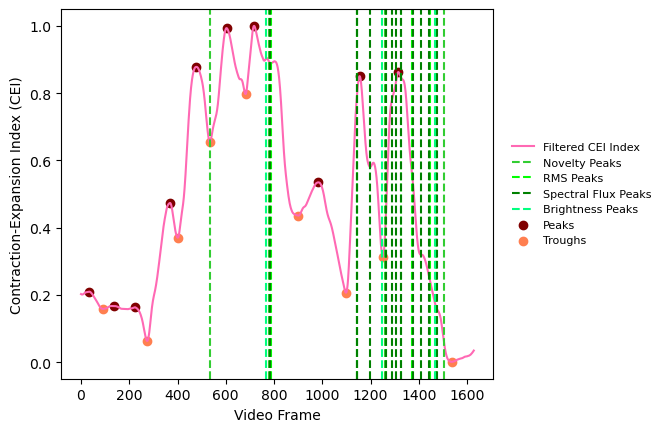

Peaks: [  34  136  223  369  478  603  717  984 1155 1315]
Troughs: [  90  274  401  534  682  900 1098 1251 1537]
Coinciding Peaks with Novelty Peaks: [(1155, 1144)]
Coinciding Peaks with RMS Peaks: [(1155, 1146)]
Coinciding Peaks with Spectral Flux Peaks: [(1155, 1145), (1315, 1306)]
Coinciding Peaks with Brightness Peaks: []
Coinciding Troughs with Novelty Peaks: [(534, 536)]
Coinciding Troughs with RMS Peaks: []
Coinciding Troughs with Spectral Flux Peaks: []
Coinciding Troughs with Brightness Peaks: [(1251, 1246)]
Number of Novelty Peaks: 5.00
Number of RMS Peaks: 7.00
Number of Spectral Flux Peaks: 11.00
Number of Brightness Peaks: 3.00
Percentage of Coinciding Peaks with Novelty Peaks: 20.00%
Percentage of Coinciding Peaks with RMS Peaks: 14.29%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 18.18%
Percentage of Coinciding Peaks with Brightness Peaks: 0.00%
Percentage of Coinciding Troughs with Novelty Peaks: 20.00%
Percentage of Coinciding Troughs with RMS Peaks: 0.00

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

#### Take 4

In [43]:
dataCopy=dfs[3].copy()

In [44]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


In [45]:
validator1_coords=[360,840,1147,1400]
novelty_peaks = [231,475,839,956,1200]
rms_peaks = [481,841,961,1020,1069,1140,1167]
spectral_flux_peaks = [480,840,892,960,983,1001,1021,1071,1106,1139,1170]
brightness_peaks = [461,941,1163]

buffer = 258
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

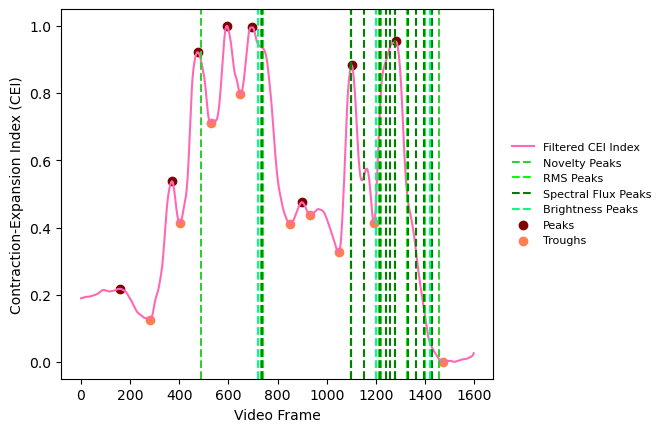

Peaks: [ 159  370  475  593  697  899 1101 1280]
Troughs: [ 281  402  528  648  852  932 1048 1192 1473]
Coinciding Peaks with Novelty Peaks: []
Coinciding Peaks with RMS Peaks: []
Coinciding Peaks with Spectral Flux Peaks: []
Coinciding Peaks with Brightness Peaks: []
Coinciding Troughs with Novelty Peaks: []
Coinciding Troughs with RMS Peaks: []
Coinciding Troughs with Spectral Flux Peaks: []
Coinciding Troughs with Brightness Peaks: [(1192, 1199)]
Number of Novelty Peaks: 5.00
Number of RMS Peaks: 7.00
Number of Spectral Flux Peaks: 11.00
Number of Brightness Peaks: 3.00
Percentage of Coinciding Peaks with Novelty Peaks: 0.00%
Percentage of Coinciding Peaks with RMS Peaks: 0.00%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Peaks with Brightness Peaks: 0.00%
Percentage of Coinciding Troughs with Novelty Peaks: 0.00%
Percentage of Coinciding Troughs with RMS Peaks: 0.00%
Percentage of Coinciding Troughs with Spectral Flux Peaks: 0.00%
Percent

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

## Phrase1_ID2

## Load data

In [58]:
data_path="C:\San\PhD-Data\AndreasBergland\AudioMostly23\MoCap_GapfFilled\GapFilled20\Phrase1_ID2_GF20.csv"

In [59]:
df=pd.read_csv(data_path).reset_index(drop=True)

In [60]:
df.isnull().sum()

BackLeft_Marker_X             0
BackLeft_Marker_Y             0
BackLeft_Marker_Z             0
BackRight_Marker_X            0
BackRight_Marker_Y            0
BackRight_Marker_Z            0
BackTop_Marker_X           4054
BackTop_Marker_Y           4054
BackTop_Marker_Z           4054
Chest_Marker_X                0
Chest_Marker_Y                0
Chest_Marker_Z                0
HeadFront_Marker_X            0
HeadFront_Marker_Y            0
HeadFront_Marker_Z            0
HeadSide_Marker_X             0
HeadSide_Marker_Y             0
HeadSide_Marker_Z             0
HeadTop_Marker_X              0
HeadTop_Marker_Y              0
HeadTop_Marker_Z              0
LAnkleOut_Marker_X            0
LAnkleOut_Marker_Y            0
LAnkleOut_Marker_Z            0
LElbowOut_Marker_X            0
LElbowOut_Marker_Y            0
LElbowOut_Marker_Z            0
LHandOut_Marker_X           105
LHandOut_Marker_Y           105
LHandOut_Marker_Z           105
LKneeOut_Marker_X             0
LKneeOut

In [61]:
df.shape

(23159, 111)

In [62]:
df=df[finalKeyPoints]

In [63]:
df

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,LWristOut_Marker_Z,RWristOut_Marker_X,RWristOut_Marker_Y,RWristOut_Marker_Z,LToeOut_Marker_X,LToeOut_Marker_Y,LToeOut_Marker_Z,RToeOut_Marker_X,RToeOut_Marker_Y,RToeOut_Marker_Z
0,0.305695,1.738109,2.500124,0.472941,0.784659,2.249442,0.468431,1.288171,2.499459,0.377866,...,2.707479,0.478697,0.862650,2.257958,0.147691,0.037509,2.528477,0.342469,0.040844,2.359501
1,0.305561,1.738066,2.500015,0.473165,0.784555,2.249688,0.469598,1.288367,2.500520,0.378015,...,2.707555,0.478972,0.862502,2.258248,0.147702,0.037522,2.528477,0.342460,0.040824,2.359511
2,0.305751,1.738122,2.499591,0.474160,0.784433,2.250069,0.470072,1.288279,2.500889,0.378088,...,2.707627,0.479185,0.862386,2.258509,0.147676,0.037482,2.528424,0.342519,0.040634,2.359293
3,0.305764,1.738112,2.499693,0.474346,0.784341,2.250291,0.470141,1.288103,2.501020,0.378101,...,2.707685,0.479211,0.862338,2.258735,0.147686,0.037484,2.528427,0.342477,0.040575,2.359279
4,0.305892,1.738166,2.498944,0.474566,0.784215,2.250520,0.470199,1.288113,2.501071,0.378193,...,2.707816,0.479428,0.862226,2.258946,0.147692,0.037494,2.528478,0.342508,0.040792,2.359521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23154,0.410112,1.715603,2.325818,0.501356,1.549717,2.505167,0.555317,1.302589,2.506105,0.397986,...,2.444276,0.554665,1.587964,2.451976,0.249519,0.036125,2.407809,0.542707,0.039748,2.298802
23155,0.409961,1.714982,2.326345,0.502059,1.549536,2.505042,0.555360,1.302587,2.506130,0.398055,...,2.444303,0.555062,1.587681,2.451755,0.249561,0.036385,2.407706,0.542485,0.039802,2.298892
23156,0.409618,1.715786,2.327971,0.503184,1.548901,2.504899,0.555423,1.302618,2.506199,0.398114,...,2.444433,0.555593,1.587396,2.451540,0.249482,0.036110,2.407772,0.542506,0.039799,2.298917
23157,0.409839,1.716435,2.328109,0.504256,1.548564,2.504862,0.555514,1.302593,2.506263,0.398191,...,2.444543,0.556221,1.587006,2.451319,0.249533,0.036363,2.407726,0.542513,0.039810,2.298907


## Split Files into separate takes

In [64]:
take_ranges = [(7962,9407), (10437,11757), (12677,13997), (15292,16687)]
dfs = [df.iloc[start:end].reset_index(drop=True) for start, end in take_ranges]

take_starts = [start for start, end in take_ranges]
tp_coords_1 = [8240,8329,8381,9094,9128]
tp_coords_2 = [10701,10785,10840,11581,11593]
tp_coords_3 = [12930,13028,13076,13801,13840]
tp_coords_4 = [15537,15613,15680,16431]

tp_coords = [[value - start for value in tp_coords] for start, tp_coords in zip(take_starts, [tp_coords_1, tp_coords_2, tp_coords_3, tp_coords_4])]

#### Take 1 

In [65]:
dataCopy=dfs[0].copy()

In [66]:
dataCopy

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,LWristOut_Marker_Z,RWristOut_Marker_X,RWristOut_Marker_Y,RWristOut_Marker_Z,LToeOut_Marker_X,LToeOut_Marker_Y,LToeOut_Marker_Z,RToeOut_Marker_X,RToeOut_Marker_Y,RToeOut_Marker_Z
0,0.193342,1.737537,2.492630,0.371035,0.771088,2.285729,0.349574,1.282069,2.518712,0.246248,...,2.649706,0.370883,0.849306,2.293608,0.132320,0.034680,2.549119,0.326945,0.041911,2.359069
1,0.193454,1.737540,2.492459,0.371070,0.771119,2.285518,0.349782,1.282043,2.518427,0.246550,...,2.649706,0.370972,0.849304,2.293414,0.132330,0.034672,2.549145,0.326955,0.041920,2.359058
2,0.193520,1.737518,2.492317,0.371139,0.771141,2.285301,0.349975,1.282099,2.518176,0.247359,...,2.649677,0.370975,0.849265,2.293169,0.132334,0.034703,2.549155,0.326958,0.041912,2.359056
3,0.193634,1.737515,2.492162,0.371227,0.771136,2.285105,0.350147,1.282087,2.517925,0.247516,...,2.649646,0.371037,0.849228,2.292994,0.132329,0.034692,2.549116,0.326959,0.041910,2.359063
4,0.193719,1.737512,2.492060,0.371328,0.771127,2.284892,0.350333,1.282116,2.517674,0.247494,...,2.649637,0.371081,0.849217,2.292772,0.132349,0.034698,2.549134,0.326982,0.041897,2.359069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,1.254217,1.350029,2.366578,0.749771,1.143981,2.387217,1.067306,1.015183,2.550134,0.961348,...,2.493016,0.781017,1.069271,2.376523,0.147701,0.071402,2.528553,1.157964,0.063171,2.421283
1441,1.253364,1.350816,2.366469,0.749274,1.143856,2.387326,1.067065,1.015784,2.550229,0.961007,...,2.493416,0.780683,1.069230,2.376705,0.147726,0.071397,2.528539,1.158177,0.063114,2.421452
1442,1.252417,1.351287,2.366040,0.748739,1.143736,2.387465,1.066715,1.016498,2.550366,0.960688,...,2.493551,0.780293,1.069237,2.376931,0.147719,0.071412,2.528527,1.158080,0.063062,2.421243
1443,1.251433,1.352025,2.365963,0.748207,1.143642,2.387626,1.066386,1.017161,2.550575,0.960342,...,2.493979,0.779922,1.069260,2.377168,0.147740,0.071431,2.528547,1.158134,0.063017,2.421242


In [67]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


In [68]:
dataCopy

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,WaistLBack_KE,WaistRBack_KE,LWristOut_KE,RWristOut_KE,LToeOut_KE,RToeOut_KE,baryCenter_X,baryCenter_Y,baryCenter_Z,contractionIndex
0,0.193342,1.737537,2.492630,0.371035,0.771088,2.285729,0.349574,1.282069,2.518712,0.246248,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.274858,1.142974,2.546858,0.495697
1,0.193454,1.737540,2.492459,0.371070,0.771119,2.285518,0.349782,1.282043,2.518427,0.246550,...,0.029582,3.376080e-04,4.329000e-04,3.280392e-04,6.048000e-06,2.174400e-06,0.275369,1.142902,2.547023,0.496237
2,0.193520,1.737518,2.492317,0.371139,0.771141,2.285301,0.349975,1.282099,2.518176,0.247359,...,0.013797,3.311333e-07,2.402172e-06,8.645766e-06,1.058879e-07,5.329062e-07,0.275795,1.142953,2.546988,0.497135
3,0.193634,1.737515,2.492162,0.371227,0.771136,2.285105,0.350147,1.282087,2.517925,0.247516,...,0.000694,2.636435e-06,6.527674e-07,2.488809e-05,4.620950e-07,1.465120e-08,0.275885,1.142903,2.546689,0.496657
4,0.193719,1.737512,2.492060,0.371328,0.771127,2.284892,0.350333,1.282116,2.517674,0.247494,...,0.000029,5.632905e-06,6.535341e-07,1.000454e-05,1.266114e-06,2.806734e-06,0.275999,1.142939,2.546421,0.496791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,1.254217,1.350029,2.366578,0.749771,1.143981,2.387217,1.067306,1.015183,2.550134,0.961348,...,0.000026,1.355248e-06,5.126004e-04,9.140022e-06,1.300122e-07,3.141872e-05,0.908158,0.962298,2.574437,0.404670
1441,1.253364,1.350816,2.366469,0.749274,1.143856,2.387326,1.067065,1.015784,2.550229,0.961007,...,0.000012,1.844835e-07,1.092931e-05,5.954607e-07,1.428948e-07,3.255779e-05,0.908000,0.962579,2.574635,0.406003
1442,1.252417,1.351287,2.366040,0.748739,1.143736,2.387465,1.066715,1.016498,2.550366,0.960688,...,0.000474,6.135945e-06,1.251146e-04,3.352161e-05,5.376054e-07,1.246216e-05,0.907796,0.962887,2.574923,0.407502
1443,1.251433,1.352025,2.365963,0.748207,1.143642,2.387626,1.066386,1.017161,2.550575,0.960342,...,0.000376,8.705984e-06,2.425808e-05,7.150927e-07,1.456888e-06,1.981838e-04,0.907632,0.963207,2.575165,0.408647


In [69]:
validator1_coords=[359,738,1229]
validator2_coords=[392,1231,1289]
novelty_peaks = [132,897]
rms_peaks = [60,125,360,913]
spectral_flux_peaks = [59,119,240,302,359,540,659,719,839,899,919]
brightness_peaks = [27,933]

buffer = 254
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

##### Contraction Index

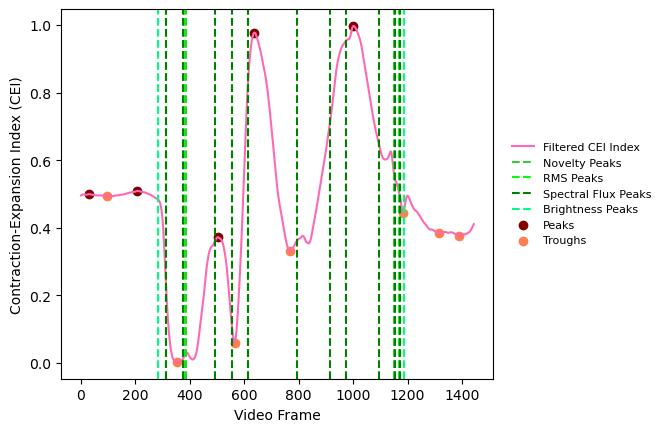

Peaks: [  30  207  502  637 1001]
Troughs: [  94  352  564  768 1183 1316 1388]
Coinciding Peaks with Novelty Peaks: []
Coinciding Peaks with RMS Peaks: []
Coinciding Peaks with Spectral Flux Peaks: []
Coinciding Peaks with Brightness Peaks: []
Coinciding Troughs with Novelty Peaks: []
Coinciding Troughs with RMS Peaks: []
Coinciding Troughs with Spectral Flux Peaks: []
Coinciding Troughs with Brightness Peaks: [(1183, 1187)]
Number of Novelty Peaks: 2.00
Number of RMS Peaks: 4.00
Number of Spectral Flux Peaks: 11.00
Number of Brightness Peaks: 2.00
Percentage of Coinciding Peaks with Novelty Peaks: 0.00%
Percentage of Coinciding Peaks with RMS Peaks: 0.00%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Peaks with Brightness Peaks: 0.00%
Percentage of Coinciding Troughs with Novelty Peaks: 0.00%
Percentage of Coinciding Troughs with RMS Peaks: 0.00%
Percentage of Coinciding Troughs with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Troughs

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

#### Take 2

In [71]:
dataCopy=dfs[1].copy()

In [72]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


##### Contraction Index

In [73]:
validator1_coords=[371,1181,1267]
validator2_coords=[311,1217]
novelty_peaks = [132,897]
rms_peaks = [60,125,360,913]
spectral_flux_peaks = [59,119,240,302,359,540,659,719,839,899,919]
brightness_peaks = [27,933]

buffer = 246
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

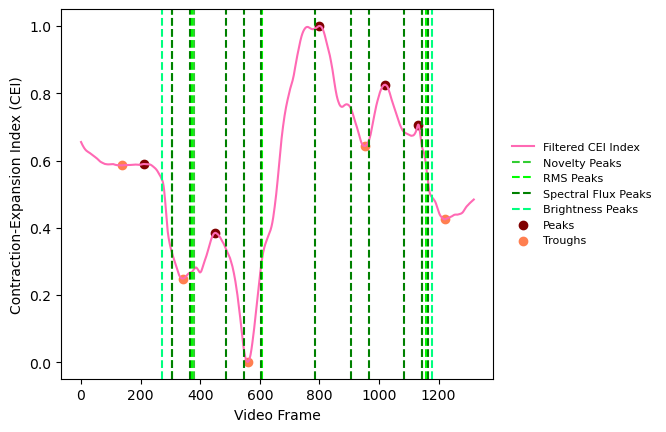

Peaks: [ 211  451  800 1021 1132]
Troughs: [ 137  341  559  952 1220]
Coinciding Peaks with Novelty Peaks: []
Coinciding Peaks with RMS Peaks: []
Coinciding Peaks with Spectral Flux Peaks: []
Coinciding Peaks with Brightness Peaks: []
Coinciding Troughs with Novelty Peaks: []
Coinciding Troughs with RMS Peaks: []
Coinciding Troughs with Spectral Flux Peaks: [(559, 548)]
Coinciding Troughs with Brightness Peaks: []
Number of Novelty Peaks: 2.00
Number of RMS Peaks: 4.00
Number of Spectral Flux Peaks: 11.00
Number of Brightness Peaks: 2.00
Percentage of Coinciding Peaks with Novelty Peaks: 0.00%
Percentage of Coinciding Peaks with RMS Peaks: 0.00%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Peaks with Brightness Peaks: 0.00%
Percentage of Coinciding Troughs with Novelty Peaks: 0.00%
Percentage of Coinciding Troughs with RMS Peaks: 0.00%
Percentage of Coinciding Troughs with Spectral Flux Peaks: 9.09%
Percentage of Coinciding Troughs with Bright

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

#### Take 3 

In [75]:
dataCopy=dfs[2].copy()

In [76]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


##### Contraction Index

In [77]:
validator1_coords=[324,577,764,1225]
validator2_coords=[332,677,1164]
novelty_peaks = [132,897]
rms_peaks = [60,125,360,913]
spectral_flux_peaks = [59,119,240,302,359,540,659,719,839,899,919]
brightness_peaks = [27,933]

buffer = 249
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

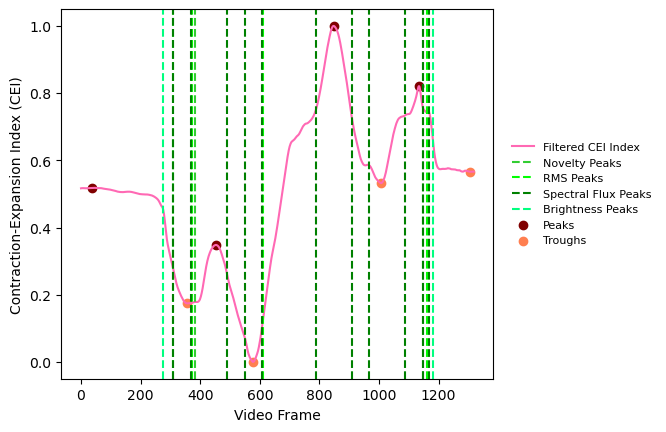

Peaks: [  38  453  848 1134]
Troughs: [ 356  577 1007 1307]
Coinciding Peaks with Novelty Peaks: []
Coinciding Peaks with RMS Peaks: []
Coinciding Peaks with Spectral Flux Peaks: []
Coinciding Peaks with Brightness Peaks: []
Coinciding Troughs with Novelty Peaks: []
Coinciding Troughs with RMS Peaks: []
Coinciding Troughs with Spectral Flux Peaks: []
Coinciding Troughs with Brightness Peaks: []
Number of Novelty Peaks: 2.00
Number of RMS Peaks: 4.00
Number of Spectral Flux Peaks: 11.00
Number of Brightness Peaks: 2.00
Percentage of Coinciding Peaks with Novelty Peaks: 0.00%
Percentage of Coinciding Peaks with RMS Peaks: 0.00%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Peaks with Brightness Peaks: 0.00%
Percentage of Coinciding Troughs with Novelty Peaks: 0.00%
Percentage of Coinciding Troughs with RMS Peaks: 0.00%
Percentage of Coinciding Troughs with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Troughs with Brightness Peaks: 0.00%


In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

#### Take 4

In [79]:
dataCopy=dfs[3].copy()

In [80]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


##### Contraction Index

In [81]:
validator1_coords=[316,709,1214]
validator2_coords=[286,299,460,578,1188]
novelty_peaks = [132,897]
rms_peaks = [60,125,360,913]
spectral_flux_peaks = [59,119,240,302,359,540,659,719,839,899,919]
brightness_peaks = [27,933]

buffer = 245
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

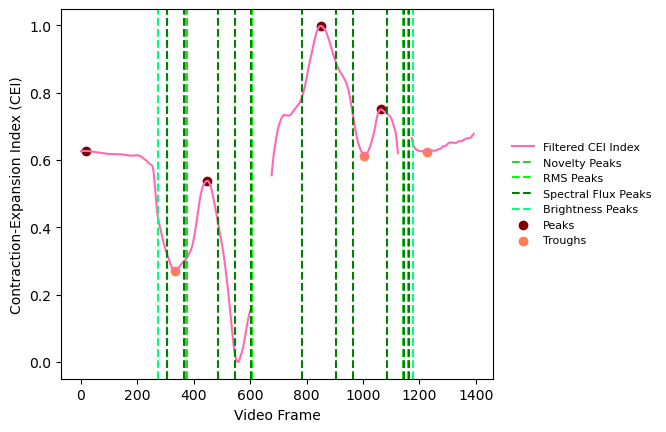

Peaks: [  17  447  850 1064]
Troughs: [ 334 1004 1226]
Coinciding Peaks with Novelty Peaks: []
Coinciding Peaks with RMS Peaks: []
Coinciding Peaks with Spectral Flux Peaks: []
Coinciding Peaks with Brightness Peaks: []
Coinciding Troughs with Novelty Peaks: []
Coinciding Troughs with RMS Peaks: []
Coinciding Troughs with Spectral Flux Peaks: []
Coinciding Troughs with Brightness Peaks: []
Number of Novelty Peaks: 2.00
Number of RMS Peaks: 4.00
Number of Spectral Flux Peaks: 11.00
Number of Brightness Peaks: 2.00
Percentage of Coinciding Peaks with Novelty Peaks: 0.00%
Percentage of Coinciding Peaks with RMS Peaks: 0.00%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Peaks with Brightness Peaks: 0.00%
Percentage of Coinciding Troughs with Novelty Peaks: 0.00%
Percentage of Coinciding Troughs with RMS Peaks: 0.00%
Percentage of Coinciding Troughs with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Troughs with Brightness Peaks: 0.00%


In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

## Phrase2_ID1

## Load data

In [83]:
data_path="C:\San\PhD-Data\AndreasBergland\AudioMostly23\MoCap_GapfFilled\GapFilled20\Phrase2_ID1_GF20.csv"

In [84]:
df=pd.read_csv(data_path).reset_index(drop=True)

In [85]:
df.isnull().sum()

BackLeft_Marker_X            0
BackLeft_Marker_Y            0
BackLeft_Marker_Z            0
BackRight_Marker_X           0
BackRight_Marker_Y           0
BackRight_Marker_Z           0
BackTop_Marker_X             0
BackTop_Marker_Y             0
BackTop_Marker_Z             0
Chest_Marker_X             452
Chest_Marker_Y             452
Chest_Marker_Z             452
HeadFront_Marker_X           0
HeadFront_Marker_Y           0
HeadFront_Marker_Z           0
HeadSide_Marker_X            0
HeadSide_Marker_Y            0
HeadSide_Marker_Z            0
HeadTop_Marker_X             0
HeadTop_Marker_Y             0
HeadTop_Marker_Z             0
LAnkleOut_Marker_X           0
LAnkleOut_Marker_Y           0
LAnkleOut_Marker_Z           0
LElbowOut_Marker_X           0
LElbowOut_Marker_Y           0
LElbowOut_Marker_Z           0
LHandOut_Marker_X            0
LHandOut_Marker_Y            0
LHandOut_Marker_Z            0
LKneeOut_Marker_X            0
LKneeOut_Marker_Y            0
LKneeOut

In [86]:
df.shape

(13659, 111)

In [87]:
df=df[finalKeyPoints]

In [88]:
df

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,LWristOut_Marker_Z,RWristOut_Marker_X,RWristOut_Marker_Y,RWristOut_Marker_Z,LToeOut_Marker_X,LToeOut_Marker_Y,LToeOut_Marker_Z,RToeOut_Marker_X,RToeOut_Marker_Y,RToeOut_Marker_Z
0,0.859994,1.640833,3.777084,1.009367,0.874074,4.227654,0.815859,1.175502,3.893702,0.719299,...,3.244874,0.998932,0.923125,4.207118,0.923421,0.036007,3.698200,1.401153,0.605774,3.421277
1,0.859911,1.640877,3.776973,1.009441,0.874120,4.227458,0.815772,1.175495,3.893614,0.719108,...,3.244851,0.998964,0.923172,4.206962,0.923379,0.036102,3.698233,1.401100,0.605559,3.421261
2,0.859807,1.640869,3.776795,1.009492,0.874115,4.227240,0.815620,1.175567,3.893555,0.719019,...,3.244850,0.999009,0.923209,4.206834,0.923375,0.036085,3.698226,1.400844,0.605602,3.421425
3,0.859684,1.640874,3.776651,1.009468,0.874151,4.227055,0.815546,1.175634,3.893578,0.718918,...,3.244829,0.998951,0.923209,4.206668,0.923312,0.035883,3.698164,1.400690,0.605514,3.421473
4,0.859512,1.640921,3.776479,1.009456,0.874156,4.226883,0.815392,1.175706,3.893426,0.718853,...,3.244772,0.998948,0.923289,4.206568,0.923258,0.035841,3.698164,1.400485,0.605464,3.421519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13654,0.449613,1.641962,2.020471,0.696966,0.764507,1.914105,0.540127,1.189324,2.122368,0.367869,...,1.929427,0.694371,0.813194,1.928812,0.318870,0.039315,1.953099,0.629685,0.041256,1.950029
13655,0.449793,1.641940,2.020481,0.696856,0.764267,1.914181,0.540084,1.189345,2.122130,0.367983,...,1.929740,0.694042,0.813101,1.928798,0.318857,0.039349,1.953079,0.629651,0.041218,1.950046
13656,0.450026,1.641876,2.020478,0.696426,0.764259,1.914234,0.540256,1.189438,2.122126,0.368107,...,1.930151,0.693748,0.813018,1.928833,0.318860,0.039360,1.953062,0.629658,0.041236,1.950036
13657,0.450176,1.641845,2.020466,0.696126,0.764207,1.914300,0.540371,1.189495,2.122012,0.368168,...,1.930578,0.693480,0.812931,1.928867,0.318838,0.039324,1.953054,0.629657,0.041219,1.950032


## Split Files into separate takes

In [89]:
take_ranges = [(3345,4605), (9475,10705)]
dfs = [df.iloc[start:end].reset_index(drop=True) for start, end in take_ranges]

take_starts = [start for start, end in take_ranges]
tp_coords_1 = [3602,3951,4029,4425]
tp_coords_2 = [9702,10026,10084,10137,10500]

tp_coords = [[value - start for value in tp_coords] for start, tp_coords in zip(take_starts, [tp_coords_1, tp_coords_2, tp_coords_3, tp_coords_4])]

#### Take 1 

In [90]:
dataCopy=dfs[0].copy()

In [91]:
dataCopy

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,LWristOut_Marker_Z,RWristOut_Marker_X,RWristOut_Marker_Y,RWristOut_Marker_Z,LToeOut_Marker_X,LToeOut_Marker_Y,LToeOut_Marker_Z,RToeOut_Marker_X,RToeOut_Marker_Y,RToeOut_Marker_Z
0,0.767991,1.642886,4.136317,0.679787,0.929690,4.619738,0.703650,1.179704,4.231984,0.650428,...,3.665760,0.683450,0.974869,4.594118,0.836737,0.033336,4.066725,1.400799,0.805997,3.730571
1,0.768331,1.642857,4.136325,0.679642,0.930050,4.620164,0.703671,1.179776,4.232119,0.650467,...,3.665909,0.683339,0.975151,4.594480,0.836609,0.033554,4.066906,1.400726,0.805808,3.730679
2,0.768659,1.642826,4.136303,0.679508,0.930444,4.620615,0.703700,1.179780,4.232189,0.650447,...,3.665882,0.683243,0.975463,4.594772,0.836809,0.033378,4.066786,1.400630,0.805588,3.730828
3,0.769036,1.642820,4.136328,0.679354,0.930973,4.621247,0.703719,1.179800,4.232314,0.650462,...,3.665718,0.683136,0.975821,4.595150,0.836795,0.033351,4.066750,1.400538,0.805416,3.730993
4,0.769339,1.642807,4.136326,0.679160,0.931243,4.621644,0.703727,1.179816,4.232413,0.650495,...,3.665848,0.683016,0.976209,4.595533,0.836843,0.033350,4.066768,1.400419,0.805263,3.731184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,1.033755,1.277007,2.972586,1.417158,1.231809,3.699480,1.041611,1.249135,3.355777,0.882772,...,2.830311,1.403362,1.249044,3.647976,1.092733,0.038547,3.368313,1.825141,0.436236,3.371199
1256,1.034164,1.277430,2.972985,1.417111,1.231686,3.700063,1.041758,1.248994,3.355889,0.882970,...,2.830539,1.403379,1.248924,3.648584,1.092675,0.038503,3.368327,1.824966,0.435696,3.372388
1257,1.034658,1.277576,2.973357,1.417056,1.231566,3.700658,1.042016,1.249059,3.356307,0.883189,...,2.830990,1.403350,1.248915,3.649274,1.092599,0.038414,3.368320,1.824879,0.435165,3.373602
1258,1.035188,1.277606,2.973506,1.416905,1.231462,3.701351,1.042282,1.249139,3.356691,0.883447,...,2.831231,1.403283,1.248905,3.649962,1.092625,0.038543,3.368345,1.824678,0.434529,3.374710


In [92]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


In [93]:
dataCopy

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,WaistLBack_KE,WaistRBack_KE,LWristOut_KE,RWristOut_KE,LToeOut_KE,RToeOut_KE,baryCenter_X,baryCenter_Y,baryCenter_Z,contractionIndex
0,0.767991,1.642886,4.136317,0.679787,0.929690,4.619738,0.703650,1.179704,4.231984,0.650428,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.739352,1.059146,4.174930,0.676957
1,0.768331,1.642857,4.136325,0.679642,0.930050,4.620164,0.703671,1.179776,4.232119,0.650467,...,7.272000e-06,9.967680e-05,0.000695,1.604801e-03,6.960168e-04,3.795408e-04,0.739349,1.059143,4.175000,0.676718
2,0.768659,1.642826,4.136303,0.679508,0.930444,4.620615,0.703700,1.179780,4.232189,0.650447,...,3.753773e-05,3.602370e-06,0.000139,8.388959e-06,2.524415e-06,2.016663e-05,0.739317,1.059131,4.175091,0.677152
3,0.769036,1.642820,4.136328,0.679354,0.930973,4.621247,0.703719,1.179800,4.232314,0.650462,...,4.030949e-06,6.641487e-07,0.000076,6.298096e-05,4.324066e-04,5.261722e-06,0.739318,1.059102,4.175195,0.677535
4,0.769339,1.642807,4.136326,0.679160,0.931243,4.621644,0.703727,1.179816,4.232413,0.650495,...,1.081430e-05,2.748829e-05,0.000002,5.146858e-06,1.237803e-07,1.992964e-06,0.739325,1.059090,4.175281,0.677489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,1.033755,1.277007,2.972586,1.417158,1.231809,3.699480,1.041611,1.249135,3.355777,0.882772,...,1.720846e-07,1.275290e-05,0.000176,2.421761e-04,1.621956e-07,9.655499e-06,1.005489,1.086842,3.462012,0.918127
1256,1.034164,1.277430,2.972985,1.417111,1.231686,3.700063,1.041758,1.248994,3.355889,0.882970,...,3.404554e-05,1.552078e-06,0.000015,1.202589e-05,1.074699e-05,7.144507e-04,1.005615,1.086788,3.462173,0.917961
1257,1.034658,1.277576,2.973357,1.417056,1.231566,3.700658,1.042016,1.249059,3.356307,0.883189,...,9.445541e-07,2.513116e-05,0.000027,3.599493e-05,1.337996e-05,7.712556e-07,1.005775,1.086850,3.462490,0.918078
1258,1.035188,1.277606,2.973506,1.416905,1.231462,3.701351,1.042282,1.249139,3.356691,0.883447,...,2.997459e-05,2.980168e-07,0.000001,3.128646e-09,2.009070e-06,8.633288e-06,1.005965,1.086965,3.462844,0.918291


In [94]:
validator1_coords=[324,1142]
novelty_peaks = [297,476,838]
rms_peaks = [300,360,481,840]
spectral_flux_peaks = [119,299,359,480,839]
brightness_peaks = [212,768]

buffer = 240
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

##### Contraction Index

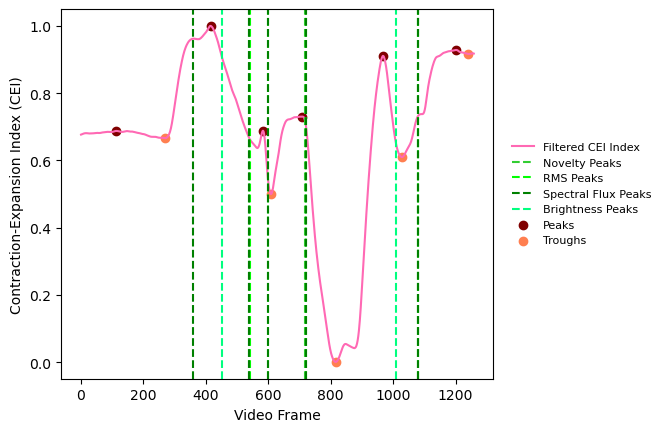

Peaks: [ 113  415  583  709  967 1202]
Troughs: [ 270  608  816 1028 1241]
Coinciding Peaks with Novelty Peaks: [(709, 716)]
Coinciding Peaks with RMS Peaks: []
Coinciding Peaks with Spectral Flux Peaks: [(583, 599)]
Coinciding Peaks with Brightness Peaks: []
Coinciding Troughs with Novelty Peaks: []
Coinciding Troughs with RMS Peaks: [(608, 600)]
Coinciding Troughs with Spectral Flux Peaks: []
Coinciding Troughs with Brightness Peaks: []
Number of Novelty Peaks: 3.00
Number of RMS Peaks: 4.00
Number of Spectral Flux Peaks: 5.00
Number of Brightness Peaks: 2.00
Percentage of Coinciding Peaks with Novelty Peaks: 33.33%
Percentage of Coinciding Peaks with RMS Peaks: 0.00%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 20.00%
Percentage of Coinciding Peaks with Brightness Peaks: 0.00%
Percentage of Coinciding Troughs with Novelty Peaks: 0.00%
Percentage of Coinciding Troughs with RMS Peaks: 25.00%
Percentage of Coinciding Troughs with Spectral Flux Peaks: 0.00%
Percentage of Coi

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

#### Take 4

In [96]:
dataCopy=dfs[1].copy()

In [97]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


##### Contraction Index

In [98]:
validator1_coords=[377,592,1132]
validator2_coords=[266,299,564,782,1040]
novelty_peaks = [297,476,838]
rms_peaks = [300,360,481,840]
spectral_flux_peaks = [119,299,359,480,839]
brightness_peaks = [212,768]

buffer = 202
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

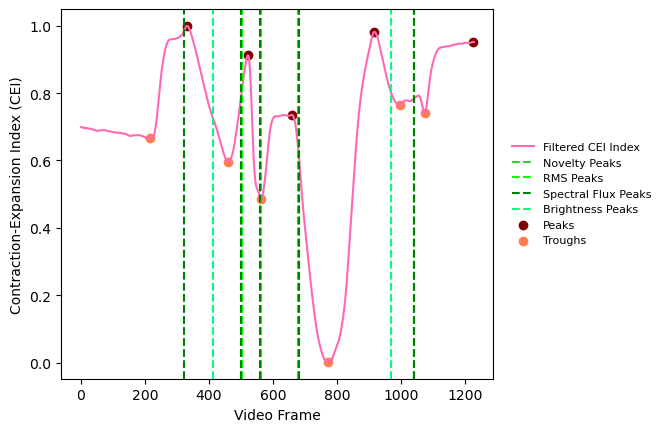

Peaks: [ 331  522  659  917 1226]
Troughs: [ 217  460  564  772  996 1074]
Coinciding Peaks with Novelty Peaks: []
Coinciding Peaks with RMS Peaks: []
Coinciding Peaks with Spectral Flux Peaks: [(331, 321)]
Coinciding Peaks with Brightness Peaks: []
Coinciding Troughs with Novelty Peaks: []
Coinciding Troughs with RMS Peaks: [(564, 562)]
Coinciding Troughs with Spectral Flux Peaks: [(564, 561)]
Coinciding Troughs with Brightness Peaks: []
Number of Novelty Peaks: 3.00
Number of RMS Peaks: 4.00
Number of Spectral Flux Peaks: 5.00
Number of Brightness Peaks: 2.00
Percentage of Coinciding Peaks with Novelty Peaks: 0.00%
Percentage of Coinciding Peaks with RMS Peaks: 0.00%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 20.00%
Percentage of Coinciding Peaks with Brightness Peaks: 0.00%
Percentage of Coinciding Troughs with Novelty Peaks: 0.00%
Percentage of Coinciding Troughs with RMS Peaks: 25.00%
Percentage of Coinciding Troughs with Spectral Flux Peaks: 20.00%
Percentage of Coi

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

## Phrase6_ID1

## Load data

In [100]:
data_path="C:\San\PhD-Data\AndreasBergland\AudioMostly23\MoCap_GapfFilled\GapFilled20\Phrase6_ID1_GF20.csv"

In [101]:
df=pd.read_csv(data_path).reset_index(drop=True)

In [102]:
df.isnull().sum()

BackLeft_Marker_X            0
BackLeft_Marker_Y            0
BackLeft_Marker_Z            0
BackRight_Marker_X           0
BackRight_Marker_Y           0
BackRight_Marker_Z           0
BackTop_Marker_X           347
BackTop_Marker_Y           347
BackTop_Marker_Z           347
Chest_Marker_X              31
Chest_Marker_Y              31
Chest_Marker_Z              31
HeadFront_Marker_X           0
HeadFront_Marker_Y           0
HeadFront_Marker_Z           0
HeadSide_Marker_X           64
HeadSide_Marker_Y           64
HeadSide_Marker_Z           64
HeadTop_Marker_X             0
HeadTop_Marker_Y             0
HeadTop_Marker_Z             0
LAnkleOut_Marker_X           0
LAnkleOut_Marker_Y           0
LAnkleOut_Marker_Z           0
LElbowOut_Marker_X           0
LElbowOut_Marker_Y           0
LElbowOut_Marker_Z           0
LHandOut_Marker_X            0
LHandOut_Marker_Y            0
LHandOut_Marker_Z            0
LKneeOut_Marker_X            0
LKneeOut_Marker_Y            0
LKneeOut

In [103]:
df.shape

(14584, 111)

In [104]:
df=df[finalKeyPoints]

In [105]:
df

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,LWristOut_Marker_Z,RWristOut_Marker_X,RWristOut_Marker_Y,RWristOut_Marker_Z,LToeOut_Marker_X,LToeOut_Marker_Y,LToeOut_Marker_Z,RToeOut_Marker_X,RToeOut_Marker_Y,RToeOut_Marker_Z
0,3.287537,1.378543,2.307509,3.306784,0.592438,2.690292,3.043337,1.160973,2.641340,2.914338,...,2.114792,3.294992,0.639097,2.683056,2.583088,0.061634,2.482252,2.999512,0.036970,2.593620
1,3.296516,1.369350,2.307290,3.309540,0.584535,2.690041,3.049182,1.157339,2.640263,2.921510,...,2.121803,3.297677,0.631040,2.682143,2.564559,0.067711,2.484404,2.999513,0.036960,2.593693
2,3.305808,1.359875,2.306783,3.311769,0.576296,2.688918,3.055029,1.153856,2.639186,2.928530,...,2.125503,3.300711,0.623044,2.681455,2.547702,0.071837,2.490395,2.999578,0.036940,2.593712
3,3.315611,1.350121,2.306341,3.314530,0.568150,2.688090,3.060964,1.150146,2.638166,2.935748,...,2.128998,3.303384,0.614605,2.680271,2.531886,0.074360,2.496423,2.999511,0.036968,2.593731
4,3.324924,1.340189,2.306145,3.317446,0.559841,2.687380,3.066849,1.146470,2.636763,2.943017,...,2.134577,3.306168,0.606229,2.679265,2.511152,0.081517,2.503762,2.999485,0.036963,2.593675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14579,-1.390389,1.643202,-1.868318,-1.302992,1.079193,-2.059430,-1.332404,1.190000,-1.744966,-1.506676,...,-2.060685,-1.284168,1.062768,-2.016789,-1.539664,0.043038,-1.925619,-1.215003,0.045521,-1.942461
14580,-1.390185,1.643265,-1.868607,-1.304814,1.078011,-2.060261,-1.332431,1.189929,-1.744980,-1.506567,...,-2.061017,-1.283585,1.064074,-2.018936,-1.539723,0.043141,-1.925660,-1.215011,0.045534,-1.942486
14581,-1.389975,1.643354,-1.868855,-1.304634,1.078535,-2.060865,-1.332473,1.189905,-1.745054,-1.505990,...,-2.060810,-1.283818,1.064924,-2.018949,-1.539672,0.043082,-1.925644,-1.215026,0.045513,-1.942511
14582,-1.389712,1.643408,-1.869141,-1.304824,1.078845,-2.061386,-1.332431,1.189787,-1.745107,-1.505832,...,-2.060943,-1.283926,1.065289,-2.019415,-1.539688,0.043075,-1.925682,-1.214982,0.045533,-1.942480


## Split Files into separate takes

In [106]:
take_ranges = [(8280,9670), (10670,12240)]
dfs = [df.iloc[start:end].reset_index(drop=True) for start, end in take_ranges]

take_starts = [start for start, end in take_ranges]

tp_coords_1 = [8489,8582,8864,9013,9126,9198,9448]
tp_coords_2 = [10892,10976,11248,11382,11504,11562,11833]

tp_coords = [[value - start for value in tp_coords] for start, tp_coords in zip(take_starts, [tp_coords_1, tp_coords_2, tp_coords_3, tp_coords_4])]

#### Take 3

In [107]:
dataCopy=dfs[0].copy()

In [108]:
dataCopy

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,LWristOut_Marker_Z,RWristOut_Marker_X,RWristOut_Marker_Y,RWristOut_Marker_Z,LToeOut_Marker_X,LToeOut_Marker_Y,LToeOut_Marker_Z,RToeOut_Marker_X,RToeOut_Marker_Y,RToeOut_Marker_Z
0,-0.086763,1.643003,5.223042,0.121856,0.757093,5.342303,-0.105656,1.187287,5.347846,-0.222515,...,4.990294,0.116943,0.808705,5.350867,-0.138043,0.037402,5.088183,0.097726,0.037736,5.284377
1,-0.086517,1.643185,5.222964,0.121861,0.757030,5.342307,-0.105548,1.187285,5.347871,-0.222399,...,4.987581,0.116958,0.808641,5.350901,-0.138047,0.037436,5.088161,0.097710,0.037724,5.284360
2,-0.086122,1.643215,5.222795,0.121834,0.756981,5.342308,-0.105436,1.187288,5.347943,-0.222321,...,4.987887,0.116959,0.808593,5.350925,-0.138050,0.037435,5.088181,0.097725,0.037731,5.284370
3,-0.085781,1.643307,5.222641,0.121779,0.756883,5.342320,-0.105352,1.187275,5.348006,-0.222209,...,4.988146,0.116943,0.808516,5.350961,-0.138074,0.037428,5.088188,0.097719,0.037755,5.284359
4,-0.085366,1.643289,5.222507,0.121771,0.756805,5.342319,-0.105208,1.187269,5.348040,-0.222062,...,4.988404,0.116925,0.808429,5.351014,-0.138080,0.037403,5.088168,0.097716,0.037737,5.284385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,2.932210,1.619381,2.935102,3.145930,0.754823,3.046777,2.977296,1.184743,3.032075,2.846767,...,2.734935,3.147889,0.804654,3.048979,3.003055,0.038359,2.707168,3.049503,0.040028,3.051877
1386,2.932399,1.619522,2.935447,3.145939,0.754717,3.047336,2.976987,1.184746,3.032465,2.846509,...,2.735088,3.147568,0.804605,3.048993,3.003040,0.038342,2.707132,3.049467,0.040019,3.051901
1387,2.932603,1.619710,2.935789,3.145280,0.754753,3.047140,2.976664,1.184667,3.032897,2.846250,...,2.735112,3.147292,0.804502,3.049206,3.003093,0.038300,2.707135,3.049491,0.040023,3.051919
1388,2.932759,1.619853,2.936155,3.145199,0.754715,3.047741,2.976152,1.184473,3.032990,2.845963,...,2.735268,3.146927,0.804403,3.049393,3.003097,0.038331,2.707196,3.049465,0.039994,3.051923


In [109]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


In [110]:
dataCopy

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,WaistLBack_KE,WaistRBack_KE,LWristOut_KE,RWristOut_KE,LToeOut_KE,RToeOut_KE,baryCenter_X,baryCenter_Y,baryCenter_Z,contractionIndex
0,-0.086763,1.643003,5.223042,0.121856,0.757093,5.342303,-0.105656,1.187287,5.347846,-0.222515,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-0.147748,1.032129,5.277353,0.260469
1,-0.086517,1.643185,5.222964,0.121861,0.757030,5.342307,-0.105548,1.187285,5.347871,-0.222399,...,1.160352e-04,1.351944e-04,7.944799e-02,0.000039,1.192320e-05,4.960800e-06,-0.147627,1.032130,5.277375,0.262833
2,-0.086122,1.643215,5.222795,0.121834,0.756981,5.342308,-0.105436,1.187288,5.347943,-0.222321,...,1.067281e-06,2.023156e-06,6.062769e-02,0.000003,3.009740e-06,3.437594e-07,-0.147516,1.032121,5.277423,0.262711
3,-0.085781,1.643307,5.222641,0.121779,0.756883,5.342320,-0.105352,1.187275,5.348006,-0.222209,...,9.371279e-06,5.090517e-07,2.034862e-05,0.000008,2.350006e-07,4.307657e-07,-0.147395,1.032112,5.277488,0.262616
4,-0.085366,1.643289,5.222507,0.121771,0.756805,5.342319,-0.105208,1.187269,5.348040,-0.222062,...,7.764971e-07,6.426118e-06,5.948207e-06,0.000002,3.147245e-07,1.584251e-07,-0.147246,1.032098,5.277533,0.262458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,2.932210,1.619381,2.935102,3.145930,0.754823,3.046777,2.977296,1.184743,3.032075,2.846767,...,8.845291e-05,5.604460e-04,3.184184e-02,0.000091,1.585111e-06,8.902550e-06,2.925029,1.032197,2.969940,0.206754
1386,2.932399,1.619522,2.935447,3.145939,0.754717,3.047336,2.976987,1.184746,3.032465,2.846509,...,3.879657e-08,1.828025e-03,8.343491e-09,0.000004,1.403659e-06,2.810898e-04,2.924767,1.032192,2.970237,0.206873
1387,2.932603,1.619710,2.935789,3.145280,0.754753,3.047140,2.976664,1.184667,3.032897,2.846250,...,1.070649e-05,5.082016e-05,3.034220e-07,0.000011,4.552850e-06,1.396575e-06,2.924463,1.032165,2.970591,0.207185
1388,2.932759,1.619853,2.936155,3.145199,0.754715,3.047741,2.976152,1.184473,3.032990,2.845963,...,1.841916e-04,2.970088e-05,6.840886e-06,0.000025,5.220204e-09,5.687818e-07,2.924129,1.032141,2.970953,0.207363


In [111]:
validator1_coords=[365,822,1223]
validator2_coords=[265,606,881]
novelty_peaks = [22,200,552,940,1103]
rms_peaks = [1,515,538]
spectral_flux_peaks = [2,515,541]
brightness_peaks = [39,540,971]

buffer = 240
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

##### Contraction Index

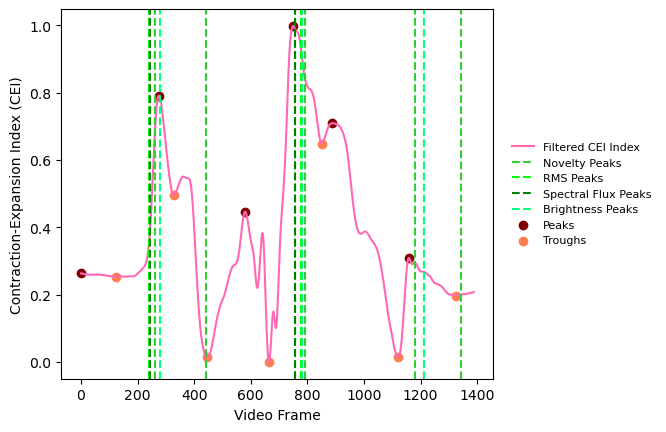

Peaks: [   1  275  580  750  888 1159]
Troughs: [ 122  328  446  664  851 1121 1326]
Coinciding Peaks with Novelty Peaks: [(275, 262)]
Coinciding Peaks with RMS Peaks: [(750, 755)]
Coinciding Peaks with Spectral Flux Peaks: [(750, 755)]
Coinciding Peaks with Brightness Peaks: [(275, 279)]
Coinciding Troughs with Novelty Peaks: [(446, 440)]
Coinciding Troughs with RMS Peaks: []
Coinciding Troughs with Spectral Flux Peaks: []
Coinciding Troughs with Brightness Peaks: []
Number of Novelty Peaks: 5.00
Number of RMS Peaks: 3.00
Number of Spectral Flux Peaks: 3.00
Number of Brightness Peaks: 3.00
Percentage of Coinciding Peaks with Novelty Peaks: 20.00%
Percentage of Coinciding Peaks with RMS Peaks: 33.33%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 33.33%
Percentage of Coinciding Peaks with Brightness Peaks: 33.33%
Percentage of Coinciding Troughs with Novelty Peaks: 20.00%
Percentage of Coinciding Troughs with RMS Peaks: 0.00%
Percentage of Coinciding Troughs with Spectral Flu

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

#### Take 4

In [113]:
dataCopy=dfs[1].copy()

In [114]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


In [115]:
validator1_coords=[293,624,740,824,1200]
validator2_coords=[287,476,826,1222]
novelty_peaks = [22,200,552,940,1103]
rms_peaks = [1,515,538]
spectral_flux_peaks = [2,515,541]
brightness_peaks = [39,540,971]

buffer = 236
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

##### Contraction Index

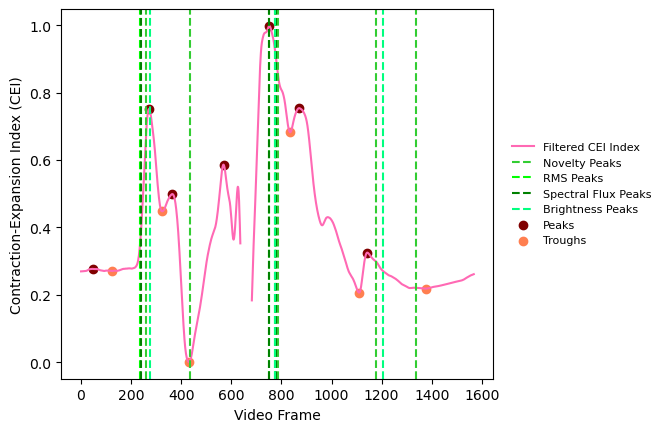

Peaks: [  47  271  364  569  752  871 1143]
Troughs: [ 123  324  430  835 1110 1377]
Coinciding Peaks with Novelty Peaks: []
Coinciding Peaks with RMS Peaks: [(752, 751)]
Coinciding Peaks with Spectral Flux Peaks: [(752, 751)]
Coinciding Peaks with Brightness Peaks: [(271, 275)]
Coinciding Troughs with Novelty Peaks: [(430, 436)]
Coinciding Troughs with RMS Peaks: []
Coinciding Troughs with Spectral Flux Peaks: []
Coinciding Troughs with Brightness Peaks: []
Number of Novelty Peaks: 5.00
Number of RMS Peaks: 3.00
Number of Spectral Flux Peaks: 3.00
Number of Brightness Peaks: 3.00
Percentage of Coinciding Peaks with Novelty Peaks: 0.00%
Percentage of Coinciding Peaks with RMS Peaks: 33.33%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 33.33%
Percentage of Coinciding Peaks with Brightness Peaks: 33.33%
Percentage of Coinciding Troughs with Novelty Peaks: 20.00%
Percentage of Coinciding Troughs with RMS Peaks: 0.00%
Percentage of Coinciding Troughs with Spectral Flux Peaks: 0.

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

## Phrase9_ID2

## Load data

In [117]:
data_path="C:\San\PhD-Data\AndreasBergland\AudioMostly23\MoCap_GapfFilled\GapFilled20\Phrase9_ID2_GF20.csv"

In [118]:
df=pd.read_csv(data_path).reset_index(drop=True)

In [119]:
df.isnull().sum()

BackLeft_Marker_X            0
BackLeft_Marker_Y            0
BackLeft_Marker_Z            0
BackRight_Marker_X           0
BackRight_Marker_Y           0
BackRight_Marker_Z           0
BackTop_Marker_X          1028
BackTop_Marker_Y          1028
BackTop_Marker_Z          1028
Chest_Marker_X            1319
Chest_Marker_Y            1319
Chest_Marker_Z            1319
HeadFront_Marker_X          70
HeadFront_Marker_Y          70
HeadFront_Marker_Z          70
HeadSide_Marker_X            0
HeadSide_Marker_Y            0
HeadSide_Marker_Z            0
HeadTop_Marker_X             0
HeadTop_Marker_Y             0
HeadTop_Marker_Z             0
LAnkleOut_Marker_X           0
LAnkleOut_Marker_Y           0
LAnkleOut_Marker_Z           0
LElbowOut_Marker_X           0
LElbowOut_Marker_Y           0
LElbowOut_Marker_Z           0
LHandOut_Marker_X          631
LHandOut_Marker_Y          631
LHandOut_Marker_Z          631
LKneeOut_Marker_X            0
LKneeOut_Marker_Y            0
LKneeOut

In [120]:
df.shape

(11347, 111)

In [121]:
df=df[finalKeyPoints]

In [122]:
df

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,LWristOut_Marker_Z,RWristOut_Marker_X,RWristOut_Marker_Y,RWristOut_Marker_Z,LToeOut_Marker_X,LToeOut_Marker_Y,LToeOut_Marker_Z,RToeOut_Marker_X,RToeOut_Marker_Y,RToeOut_Marker_Z
0,0.160646,1.644300,1.119215,0.203156,1.120384,0.894841,0.322295,1.223790,1.267960,0.164261,...,1.005636,0.251975,1.099695,0.946176,-0.343928,0.040980,1.076739,0.700197,0.041313,1.067465
1,0.160497,1.644017,1.119375,0.201796,1.120650,0.895489,0.322007,1.223421,1.267223,0.164554,...,1.005779,0.251144,1.100030,0.946521,-0.343974,0.040945,1.076753,0.700162,0.041348,1.067594
2,0.160194,1.643752,1.119639,0.200592,1.120809,0.896264,0.322324,1.223289,1.267095,0.164823,...,1.005869,0.250176,1.100112,0.946917,-0.343983,0.040929,1.076752,0.700167,0.041307,1.067614
3,0.160000,1.643441,1.119830,0.199283,1.121014,0.897031,0.322577,1.223144,1.266996,0.165130,...,1.006006,0.249331,1.100108,0.947231,-0.344013,0.040963,1.076780,0.700173,0.041293,1.067585
4,0.159826,1.643162,1.119989,0.197856,1.121307,0.897860,0.322928,1.222994,1.266955,0.165384,...,1.010223,0.248522,1.100182,0.947487,-0.344014,0.040953,1.076783,0.700202,0.041276,1.067600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11342,-0.801411,1.723861,-1.255312,-0.699436,1.079187,-1.076502,-0.785950,1.317620,-1.053774,-0.941109,...,NaN,-0.648647,1.105364,-1.075233,-1.101901,0.057324,-1.505605,-0.714077,0.042762,-1.192289
11343,-0.801079,1.724046,-1.254780,-0.699486,1.078981,-1.076872,-0.785815,1.317219,-1.053670,-0.941210,...,NaN,-0.648845,1.105252,-1.075333,-1.101997,0.057259,-1.505646,-0.714035,0.042769,-1.192318
11344,-0.800798,1.724132,-1.254354,-0.699657,1.078853,-1.077135,-0.786082,1.317044,-1.053454,-0.941265,...,NaN,-0.649093,1.105196,-1.075276,-1.100727,0.053954,-1.504775,-0.714038,0.042803,-1.192295
11345,-0.800526,1.724254,-1.253875,-0.699753,1.078674,-1.077404,-0.783182,1.312636,-1.052610,-0.941374,...,NaN,-0.649357,1.105223,-1.074936,-1.100817,0.053833,-1.504798,-0.714026,0.042784,-1.192308


## Split Files into separate takes

In [123]:
take_ranges = [(3996,5316), (8146,9456)]
dfs = [df.iloc[start:end].reset_index(drop=True) for start, end in take_ranges]

take_starts = [start for start, end in take_ranges]

tp_coords_1 = [4266,4510,4803]
tp_coords_2 = [8378,8636,8917]

tp_coords = [[value - start for value in tp_coords] for start, tp_coords in zip(take_starts, [tp_coords_1, tp_coords_2, tp_coords_3, tp_coords_4])]

#### Take 2

In [124]:
dataCopy=dfs[0].copy()

In [125]:
dataCopy

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,LWristOut_Marker_Z,RWristOut_Marker_X,RWristOut_Marker_Y,RWristOut_Marker_Z,LToeOut_Marker_X,LToeOut_Marker_Y,LToeOut_Marker_Z,RToeOut_Marker_X,RToeOut_Marker_Y,RToeOut_Marker_Z
0,-0.005104,0.575174,0.666841,0.313566,0.395420,0.931578,0.093146,0.901727,1.001791,-0.085917,...,1.010068,0.311004,0.466231,0.962382,-0.554101,0.039164,1.076514,0.539753,0.041305,1.053406
1,-0.004844,0.575065,0.667030,0.313149,0.395288,0.931407,0.093053,0.901642,1.002043,-0.085947,...,1.010113,0.310907,0.466187,0.962432,-0.553116,0.039779,1.077293,0.539774,0.041319,1.053384
2,-0.004677,0.574984,0.667201,0.313064,0.395278,0.931383,0.092962,0.901522,1.002289,-0.086132,...,1.010114,0.310862,0.466244,0.962480,-0.553126,0.039743,1.077329,0.539697,0.041293,1.053394
3,-0.004423,0.574933,0.667460,0.312998,0.395288,0.931379,0.092931,0.901885,1.002264,-0.086256,...,1.010190,0.310786,0.466211,0.962555,-0.553774,0.038928,1.076484,0.539694,0.041300,1.053410
4,-0.004243,0.574797,0.667665,0.312932,0.395354,0.931385,0.092778,0.901797,1.002561,-0.087428,...,1.010249,0.310766,0.466213,0.962634,-0.554083,0.039171,1.076569,0.539686,0.041332,1.053398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,-0.008751,1.332888,1.852645,0.074168,1.767415,1.575408,0.098479,1.148449,1.649141,-0.077080,...,1.594567,0.119203,1.738575,1.569305,-0.564074,0.044327,1.538514,0.558974,0.046146,1.530845
1316,-0.008741,1.333521,1.851933,0.074501,1.767427,1.574215,0.098579,1.148524,1.648687,-0.077396,...,1.593499,0.120990,1.738844,1.568687,-0.564107,0.044568,1.538417,0.559054,0.046104,1.530839
1317,-0.008689,1.334279,1.851216,0.074717,1.767392,1.573248,0.098647,1.148557,1.648226,-0.076815,...,1.592550,0.121491,1.738688,1.567754,-0.564101,0.044345,1.538556,0.559407,0.046220,1.531025
1318,-0.008657,1.335047,1.850423,0.075213,1.767015,1.572416,0.098687,1.148644,1.647801,-0.076743,...,1.591416,0.119952,1.738452,1.563981,-0.564131,0.044576,1.538430,0.559465,0.046157,1.531044


In [126]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


In [127]:
dataCopy

,HeadTop_Marker_X,HeadTop_Marker_Y,HeadTop_Marker_Z,RHandOut_Marker_X,RHandOut_Marker_Y,RHandOut_Marker_Z,BackRight_Marker_X,BackRight_Marker_Y,BackRight_Marker_Z,BackLeft_Marker_X,...,WaistLBack_KE,WaistRBack_KE,LWristOut_KE,RWristOut_KE,LToeOut_KE,RToeOut_KE,baryCenter_X,baryCenter_Y,baryCenter_Z,contractionIndex
0,-0.005104,0.575174,0.666841,0.313566,0.395420,0.931578,0.093146,0.901727,1.001791,-0.085917,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.005808,0.851034,1.158113,0.010582
1,-0.004844,0.575065,0.667030,0.313149,0.395288,0.931407,0.093053,0.901642,1.002043,-0.085947,...,0.001996,0.001696,1.253160e-04,0.000100,1.407810e-02,8.071200e-06,0.005675,0.850875,1.158422,0.009131
2,-0.004677,0.574984,0.667201,0.313064,0.395278,0.931383,0.092962,0.901522,1.002289,-0.086132,...,0.000617,0.000215,5.009401e-06,0.000007,1.305274e-02,1.686833e-05,0.005558,0.850693,1.158582,0.008529
3,-0.004423,0.574933,0.667460,0.312998,0.395288,0.931379,0.092931,0.901885,1.002264,-0.086256,...,0.000534,0.000681,4.431371e-05,0.000004,1.196422e-02,2.964255e-05,0.005373,0.850571,1.158735,0.009273
4,-0.004243,0.574797,0.667665,0.312932,0.395354,0.931385,0.092778,0.901797,1.002561,-0.087428,...,0.000572,0.000006,1.728389e-05,0.000007,6.345212e-03,2.174817e-06,0.005060,0.850503,1.158492,0.008253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,-0.008751,1.332888,1.852645,0.074168,1.767415,1.575408,0.098479,1.148449,1.649141,-0.077080,...,0.000060,0.001450,1.031490e-04,0.000019,4.212083e-08,6.499313e-08,0.014864,1.013415,1.634550,0.613827
1316,-0.008741,1.333521,1.851933,0.074501,1.767427,1.574215,0.098579,1.148524,1.648687,-0.077396,...,0.001483,0.000238,9.903943e-05,0.004313,1.395702e-06,5.635087e-06,0.014998,1.013334,1.634424,0.614699
1317,-0.008689,1.334279,1.851216,0.074717,1.767392,1.573248,0.098647,1.148557,1.648226,-0.076815,...,0.000209,0.002734,1.458920e-04,0.005074,6.721967e-09,7.603648e-04,0.015107,1.013413,1.634267,0.615261
1318,-0.008657,1.335047,1.850423,0.075213,1.767015,1.572416,0.098687,1.148644,1.647801,-0.076743,...,0.002758,0.000010,3.074985e-04,0.065285,2.856295e-08,7.737054e-04,0.015116,1.013467,1.634017,0.615294


In [128]:
validator1_coords=[348,451,804,1126]
novelty_peaks = [180,476,785]
rms_peaks = [117,480,570,605,628,656,715,736,778]
spectral_flux_peaks = [119,479,627,718,780]
brightness_peaks = [467,802]

buffer = 316
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

##### Contraction Index

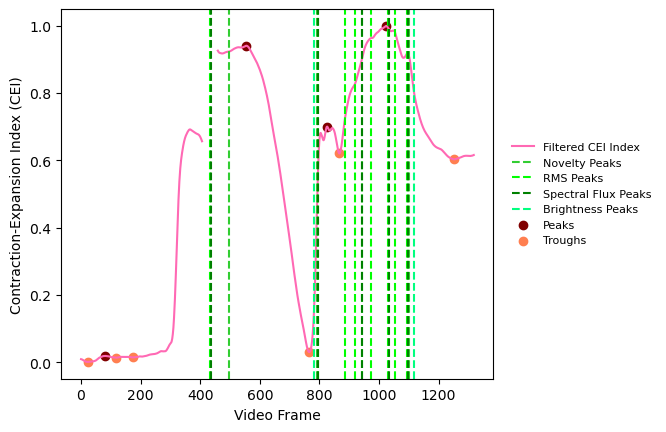

Peaks: [  82  555  826 1024]
Troughs: [  23  116  174  766  867 1252]
Coinciding Peaks with Novelty Peaks: []
Coinciding Peaks with RMS Peaks: [(1024, 1031)]
Coinciding Peaks with Spectral Flux Peaks: [(1024, 1034)]
Coinciding Peaks with Brightness Peaks: []
Coinciding Troughs with Novelty Peaks: []
Coinciding Troughs with RMS Peaks: []
Coinciding Troughs with Spectral Flux Peaks: []
Coinciding Troughs with Brightness Peaks: []
Number of Novelty Peaks: 3.00
Number of RMS Peaks: 9.00
Number of Spectral Flux Peaks: 5.00
Number of Brightness Peaks: 2.00
Percentage of Coinciding Peaks with Novelty Peaks: 0.00%
Percentage of Coinciding Peaks with RMS Peaks: 11.11%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 20.00%
Percentage of Coinciding Peaks with Brightness Peaks: 0.00%
Percentage of Coinciding Troughs with Novelty Peaks: 0.00%
Percentage of Coinciding Troughs with RMS Peaks: 0.00%
Percentage of Coinciding Troughs with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Trou

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))

#### Take 4

In [130]:
dataCopy=dfs[1].copy()

In [131]:
dataCopy = get_contractionIndex(get_baryCenter(get_KE(get_acceleration(get_velocity(get_distance(dataCopy))), 1)))

HeadTop_d
RHandOut_d
BackRight_d
BackLeft_d
WaistLBack_d
WaistRBack_d
LWristOut_d
RWristOut_d
LToeOut_d
RToeOut_d
HeadTop_v
RHandOut_v
BackRight_v
BackLeft_v
WaistLBack_v
WaistRBack_v
LWristOut_v
RWristOut_v
LToeOut_v
RToeOut_v
HeadTop_a
RHandOut_a
BackRight_a
BackLeft_a
WaistLBack_a
WaistRBack_a
LWristOut_a
RWristOut_a
LToeOut_a
RToeOut_a
HeadTop_KE
RHandOut_KE
BackRight_KE
BackLeft_KE
WaistLBack_KE
WaistRBack_KE
LWristOut_KE
RWristOut_KE
LToeOut_KE
RToeOut_KE
baryCenter


In [132]:
validator1_coords=[301,760,1140]
novelty_peaks = [180,476,785]
rms_peaks = [117,480,570,605,628,656,715,736,778]
spectral_flux_peaks = [119,479,627,718,780]
brightness_peaks = [467,802]

buffer = 293
novelty_peaks = [x+buffer for x in novelty_peaks]
rms_peaks = [x+buffer for x in rms_peaks]
spectral_flux_peaks = [x+buffer for x in spectral_flux_peaks]
brightness_peaks = [x+buffer for x in brightness_peaks]

##### Contraction Index

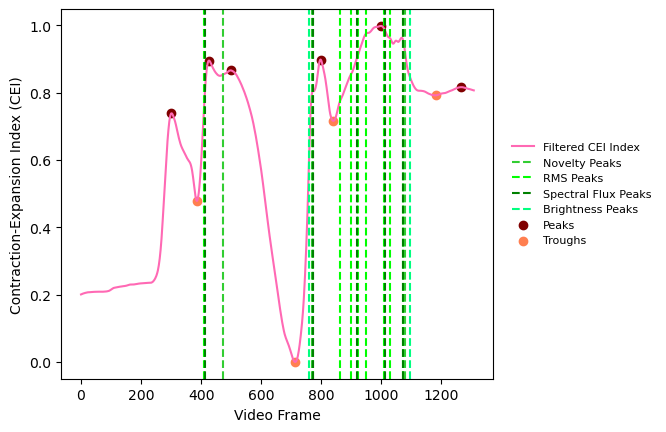

Peaks: [ 301  426  498  798  998 1267]
Troughs: [ 386  714  840 1181]
Coinciding Peaks with Novelty Peaks: []
Coinciding Peaks with RMS Peaks: []
Coinciding Peaks with Spectral Flux Peaks: []
Coinciding Peaks with Brightness Peaks: []
Coinciding Troughs with Novelty Peaks: []
Coinciding Troughs with RMS Peaks: []
Coinciding Troughs with Spectral Flux Peaks: []
Coinciding Troughs with Brightness Peaks: []
Number of Novelty Peaks: 3.00
Number of RMS Peaks: 9.00
Number of Spectral Flux Peaks: 5.00
Number of Brightness Peaks: 2.00
Percentage of Coinciding Peaks with Novelty Peaks: 0.00%
Percentage of Coinciding Peaks with RMS Peaks: 0.00%
Percentage of Coinciding Peaks with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Peaks with Brightness Peaks: 0.00%
Percentage of Coinciding Troughs with Novelty Peaks: 0.00%
Percentage of Coinciding Troughs with RMS Peaks: 0.00%
Percentage of Coinciding Troughs with Spectral Flux Peaks: 0.00%
Percentage of Coinciding Troughs with Brightness Peaks:

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, argrelextrema

# Replace this with your actual DataFrame
df=dataCopy[1:]

# Smooth the input data using the Savitzky-Golay filter
smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Find the prominent peaks and troughs
peaks = argrelextrema(smoothed_data, np.greater, order=50, mode='clip')[0]
troughs = argrelextrema(smoothed_data, np.less, order=50, mode='clip')[0]

# peaks = peaks[3:]
# troughs = troughs[3:]

# Create the line plot
# plt.plot(df['contractionIndex'], alpha=0.3, label='Original Data')
plt.plot(smoothed_data, label='Filtered CEI Index', color='hotpink')
plt.xlabel('Video Frame')
plt.ylabel('Contraction-Expansion Index (CEI)')
# plt.title('Plot indicating CEI with its peaks \nand vertical lines for RMS, Novelty, Spectral Flux, and Brightness peaks')

# Add vertical lines for bins, validator1_coords, validator2_coords, novelty_peaks, and rms_peaks
def add_vertical_lines(coords, color, label, linestyle='--'):
    for i, coord in enumerate(coords):
        plt.axvline(x=coord, color=color, linestyle=linestyle, label=label if i == 0 else None)

num_bins = len(df) // 20 + (len(df) % 20 != 0)

# for i in range(1, num_bins):
#     plt.axvline(x=i * 20, color='red', linestyle='--', label='Bins' if i == 1 else None)

# validator1_coords = [569, 1028, 1148, 1451, 1703]
# validator2_coords = [632, 1143, 1447, 1668]
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# add_vertical_lines(validator1_coords, 'blue', 'Validator 1')
# add_vertical_lines(validator2_coords, 'green', 'Validator 2')
add_vertical_lines(novelty_peaks, 'limegreen', 'Novelty Peaks')
add_vertical_lines(rms_peaks, 'lime', 'RMS Peaks')
add_vertical_lines(spectral_flux_peaks, 'green', 'Spectral Flux Peaks')
add_vertical_lines(brightness_peaks, 'springgreen', 'Brightness Peaks')

# Plot peaks and troughs
plt.scatter(peaks, smoothed_data[peaks], color='maroon', marker='o', label='Peaks')
plt.scatter(troughs, smoothed_data[troughs], color='coral', marker='o', label='Troughs')

# Set font size for legend
font_size = 8

# Add legend to the right of the plot
leg = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size, frameon=False)

# Adjust the plot margins
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()


def find_coinciding_frames(peak_trough_frames, reference_frames):
    coinciding_frames = []
    for frame in peak_trough_frames:
        bin_start = frame // 20 * 20
        bin_end = bin_start + 20
        for ref_frame in reference_frames:
            if bin_start <= ref_frame < bin_end:
                coinciding_frames.append((frame, ref_frame))
                break
    return coinciding_frames

# # Replace this with your actual DataFrame
# df=dataCopy[1:]

# # Smooth the input data using the Savitzky-Golay filter
# smoothed_data = savgol_filter(df['contractionIndex'], 21, 3)

# # Find the peaks and troughs
# peaks = argrelextrema(smoothed_data, np.greater)[0]
# troughs = argrelextrema(smoothed_data, np.less)[0]

# Print the values of peaks and troughs
print("Peaks:", peaks)
print("Troughs:", troughs)

# Check for coinciding frames
# novelty_peaks = [231, 475, 839, 897, 956]
# rms_peaks = [480, 842, 960, 1020, 1069, 1139, 1168]

# Calculate peaks
coinciding_peaks_novelty = find_coinciding_frames(peaks, novelty_peaks)
coinciding_peaks_rms = find_coinciding_frames(peaks, rms_peaks)
coinciding_peaks_spectral_flux = find_coinciding_frames(peaks, spectral_flux_peaks)
coinciding_peaks_brightness = find_coinciding_frames(peaks, brightness_peaks)


# Calculate troughs
coinciding_troughs_novelty = find_coinciding_frames(troughs, novelty_peaks)
coinciding_troughs_rms = find_coinciding_frames(troughs, rms_peaks)
coinciding_troughs_spectral_flux = find_coinciding_frames(troughs, spectral_flux_peaks)
coinciding_troughs_brightness = find_coinciding_frames(troughs, brightness_peaks)

print("Coinciding Peaks with Novelty Peaks:", coinciding_peaks_novelty)
print("Coinciding Peaks with RMS Peaks:", coinciding_peaks_rms)
print("Coinciding Peaks with Spectral Flux Peaks:", coinciding_peaks_spectral_flux)
print("Coinciding Peaks with Brightness Peaks:", coinciding_peaks_brightness)


print("Coinciding Troughs with Novelty Peaks:", coinciding_troughs_novelty)
print("Coinciding Troughs with RMS Peaks:", coinciding_troughs_rms)
print("Coinciding Troughs with Spectral Flux Peaks:", coinciding_troughs_spectral_flux)
print("Coinciding Troughs with Brightness Peaks:", coinciding_troughs_brightness)


def calculate_percentage_coinciding(coinciding_frames, reference_frames):
    return len(coinciding_frames) / len(reference_frames) * 100

percentage_coinciding_peaks_novelty = calculate_percentage_coinciding(coinciding_peaks_novelty, novelty_peaks)
percentage_coinciding_peaks_rms = calculate_percentage_coinciding(coinciding_peaks_rms, rms_peaks)
percentage_coinciding_peaks_spectral_flux = calculate_percentage_coinciding(coinciding_peaks_spectral_flux, spectral_flux_peaks)
percentage_coinciding_peaks_brightness = calculate_percentage_coinciding(coinciding_peaks_brightness, brightness_peaks)


percentage_coinciding_troughs_novelty = calculate_percentage_coinciding(coinciding_troughs_novelty, novelty_peaks)
percentage_coinciding_troughs_rms = calculate_percentage_coinciding(coinciding_troughs_rms, rms_peaks)
percentage_coinciding_troughs_spectral_flux = calculate_percentage_coinciding(coinciding_troughs_spectral_flux, spectral_flux_peaks)
percentage_coinciding_troughs_brightness = calculate_percentage_coinciding(coinciding_troughs_brightness, brightness_peaks)

print("Number of Novelty Peaks: {:.2f}".format(len(novelty_peaks)))
print("Number of RMS Peaks: {:.2f}".format(len(rms_peaks)))
print("Number of Spectral Flux Peaks: {:.2f}".format(len(spectral_flux_peaks)))
print("Number of Brightness Peaks: {:.2f}".format(len(brightness_peaks)))

print("Percentage of Coinciding Peaks with Novelty Peaks: {:.2f}%".format(percentage_coinciding_peaks_novelty))
print("Percentage of Coinciding Peaks with RMS Peaks: {:.2f}%".format(percentage_coinciding_peaks_rms))
print("Percentage of Coinciding Peaks with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_peaks_spectral_flux))
print("Percentage of Coinciding Peaks with Brightness Peaks: {:.2f}%".format(percentage_coinciding_peaks_brightness))

print("Percentage of Coinciding Troughs with Novelty Peaks: {:.2f}%".format(percentage_coinciding_troughs_novelty))
print("Percentage of Coinciding Troughs with RMS Peaks: {:.2f}%".format(percentage_coinciding_troughs_rms))
print("Percentage of Coinciding Troughs with Spectral Flux Peaks: {:.2f}%".format(percentage_coinciding_troughs_spectral_flux))
print("Percentage of Coinciding Troughs with Brightness Peaks: {:.2f}%".format(percentage_coinciding_troughs_brightness))